# Demonstration of Dynamic Network Weighting

TODO: Consider changing title. 

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict

import sys
sys.path.append("..")

## Background

* There are three *groups* of NFTS: Red, Blue, and Yellow.
* Within each group, there are two different types of NFTs, numbered 1 and 2. So there are $RED_1$, $RED_2$, $BLUE_1$, etc. 
* Each eligible voter holds at least one of these NFTs. 
* Overall, Red NFTs are rarest and represent the most value. Comparatively, Blue and Yellow NFTs are easier to get. 
* However, there is no requirement that the two types of NFTs within a given 
* The *cweight* of an individual credential is defined to be 
$cweight = \text{Number of Credential Holders} \times \text{Credential Weight}$.
* The *cweight* of a group of NFTs is just the sum of the *cweight* of each individual credential. 
* **Fundamental Property:** For this example, the cweights should satisfy:
$$ Red cweight \geq Blue cweight = Yellow cweight.$$ This reflects the greater insight of Red NFT holders in the community. 

## Accessing Credential Information

### Background 
To begin, we need data about the voters and their credentials (e.g. NFTs and tokens). 

This is input in the form of a .csv file with
* a column called `voter` that contains voter IDs (e.g. wallet addresses)
*  columns are **RED**, **BLUE**, and **YELLOW** 
* each entry is either 1 or 0, corresponding to ownership or non-ownership of the particular NFT. 

### Mechanics 
1. Make sure that this .ipynb file is in the same directory as the voter data. 
2. To use your own data, change the value of `VOTER_INFO_FILE` from `default_voter_data.csv` to the string of your own filename. 

In [32]:
# Code to read in a file 
VOTER_INFO_FILE = "data/default_voter_data.csv"

In [33]:
## Accessing Credential Information


In [34]:
# Read Initial Data From csv file
voter_cred_df = pd.read_csv(VOTER_INFO_FILE, index_col = 'voter')

#TODO: Move to uilts for processing
def voter_cred_df_to_dict(voter_cred_df: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    voter_cred_dict = {}
    for voter in list(voter_cred_df.index):
        voter_cred_dict[voter] = {}
        for cred in list(voter_cred_df.columns):
            voter_cred_dict[voter][cred] = voter_cred_df.at[voter,cred]
    return voter_cred_dict

In [35]:
voter_cred_dict = voter_cred_df_to_dict(voter_cred_df)
voter_cred_dict

{'voter_0': {'red_1': 0,
  'red_2': 1,
  'blue_1': 1,
  'blue_2': 1,
  'yellow_1': 0,
  'yellow_2': 1},
 'voter_1': {'red_1': 1,
  'red_2': 0,
  'blue_1': 0,
  'blue_2': 0,
  'yellow_1': 0,
  'yellow_2': 0},
 'voter_2': {'red_1': 0,
  'red_2': 0,
  'blue_1': 0,
  'blue_2': 0,
  'yellow_1': 0,
  'yellow_2': 1},
 'voter_3': {'red_1': 0,
  'red_2': 0,
  'blue_1': 1,
  'blue_2': 0,
  'yellow_1': 1,
  'yellow_2': 0},
 'voter_4': {'red_1': 0,
  'red_2': 0,
  'blue_1': 1,
  'blue_2': 0,
  'yellow_1': 0,
  'yellow_2': 1}}

## Assigning Initial Weights

One way to get started is to assign some initial weights to get the process started, to indicate domain expert knowledge of relative importance. 

By default, all weights are set equal to 1.0. To change this, type new values in the textbox. 

**NOTE:** The re-weighting will respect the initialrelative weights assigned within groups. For instance, if the initial weight of `red_1` is 3.0 and the initial weight of `red_2` is 2.0, the final weights will also have `red_1/red_2 = 1.5`. 

In [36]:
from ipywidgets import FloatText, HTML, Button, HBox, VBox

total_weight = 0

weights = {}
weights["red_1"] = FloatText(description='red_1', value=1.0, layout={'width': '200px'})
weights["blue_1"] = FloatText(description='blue_1', value=1.0, layout={'width': '200px'})
weights["yellow_1"] = FloatText(description='yellow_1', value=1.0, layout={'width': '200px'})
weights["red_2"] = FloatText(description='red_2', value=1.0, layout={'width': '200px'})
weights["blue_2"] = FloatText(description='blue_2', value=1.0, layout={'width': '200px'})
weights["yellow_2"] = FloatText(description='yellow_2', value=1.0, layout={'width': '200px'})
total_weight_widget = HTML(value=f"Total weight: {total_weight}")



def update_total_weight(b):
    total_weight = sum(weight.value for weight in weights.values())
    total_weight_widget.value = f"Total weight: {total_weight}"

# Add a title for the widget box
title_widget = HTML(value="<h2> Assign Weights Below </h2>")

# Create two columns for weights
weights_column_1 = VBox([weights["red_1"], weights["blue_1"], weights["yellow_1"]])
weights_column_2 = VBox([weights["red_2"], weights["blue_2"], weights["yellow_2"]])  # This column is intentionally left empty to maintain the two-column layout
weights_columns = HBox([weights_column_1, weights_column_2])

# Create a box for the update button and total weight display
update_total_weight_box = VBox([Button(description="Update Total Weight", on_click=update_total_weight), HTML(value="Total weight:")])

# Combine the weights columns and the update box
combined_widget_box = VBox([title_widget, weights_columns, update_total_weight_box])
display(combined_widget_box)

# TODO: Make it so the total weight value updates on the button click. 
# TODO: Add a table summarizing relative weights. 

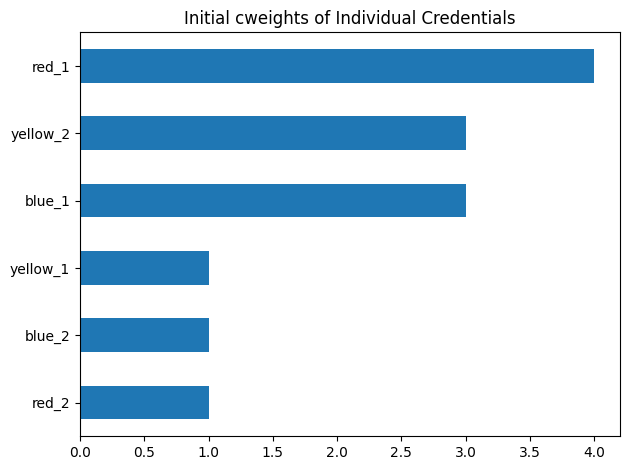

In [44]:

# Plot Initial Weights

cweight_values = [voter_cred_df[col].sum() * weights.get(col).value 
                  for col in voter_cred_df.columns]
cweight_values_array = np.array(cweight_values)
cred_names = list(voter_cred_df.columns)

initial_cweights = pd.Series(
    cweight_values_array, index=cred_names
).sort_values(ascending=True)

ax = initial_cweights.plot(kind='barh')
ax.set_title("Initial cweights of Individual Credentials")
ax.figure.tight_layout()

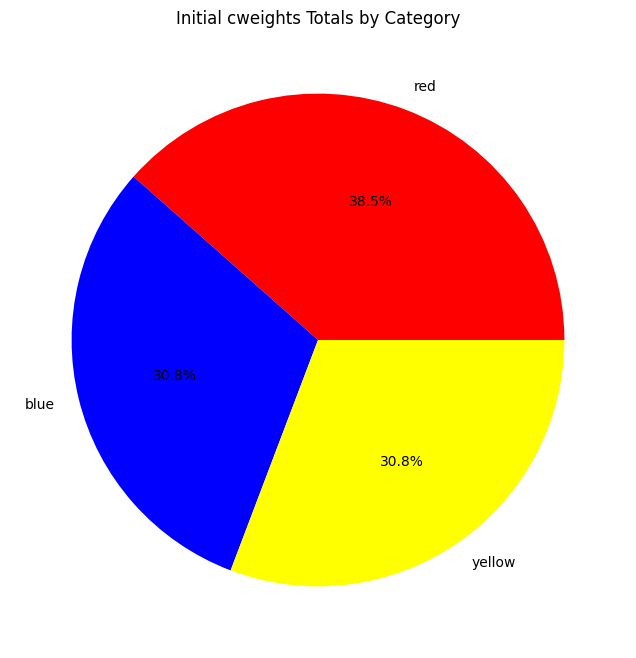

In [45]:
def calculate_cweight_totals(color_creds, initial_cweights):
    return {
        color: initial_cweights[creds].sum() for color, creds in color_creds.items()
    }

# Example usage
color_creds = {
    "red": ["red_1", "red_2"],
    "blue": ["blue_1", "blue_2"],
    "yellow": ["yellow_1", "yellow_2"]
}

initial_cweights_totals = calculate_cweight_totals(color_creds, initial_cweights)

plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'yellow']
plt.pie(initial_cweights_totals.values(), labels=initial_cweights_totals.keys(), autopct='%1.1f%%', colors=colors)
plt.title('Initial cweights Totals by Category')
plt.show()


In [46]:
def calculate_voter_weights(voter_cred_df, weights):
    """
    Calculate the total weight of each voter based on their credentials and the weights assigned to each credential.

    Parameters:
    - voter_cred_df (DataFrame): A DataFrame where each row represents a voter and each column represents a credential.
    - weights (dict): A dictionary where each key is a credential and the value is the weight assigned to that credential.

    Returns:
    - Series: A Series where each index is a voter and the value is their total weight.
    """
    # Initialize a Series to store the total weight of each voter
    voter_weights = pd.Series(index=voter_cred_df.index)
    
    # Iterate over each voter
    for voter in voter_cred_df.index:
        # Initialize the total weight for the current voter
        total_weight = 0
        
        # Iterate over each credential of the current voter
        for credential, value in voter_cred_df.loc[voter].items():
            # Add the weighted value of the credential to the total weight
            total_weight += value * weights.get(credential).value
        
        # Store the total weight of the voter
        voter_weights[voter] = total_weight
    
    return voter_weights


In [47]:
voter_weights = calculate_voter_weights(voter_cred_df, weights)

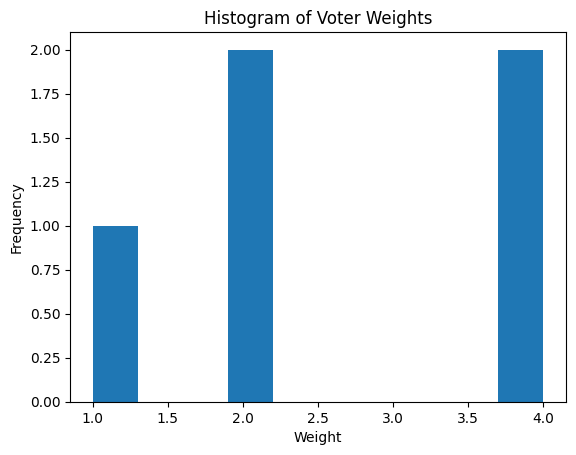

In [48]:
voter_weights.hist(grid=False)
plt.title('Histogram of Voter Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

## Re-weighting to Achieve Desired Properties 

TODO: For the time being, we could set a single example set of requirements: RED >= GREEN == BLUE.
 Moving to arbitrary requireemnts will be possible, but probably beyond current scope. 

In [49]:
def reweight_creds():
    # TODO: Implement logic to reweight so that properties are met. 
    pass 

## Visualizing Impact of Re-weighting

TODO 

## Choosing a Voting Mechanism

The properties of the voting are sensitive to the **aggregation rule** (vote processing rule) that turns ballots into winners, based on voter weights, as much as they are voter weights.

For the time being we assume rules possess **monotonicity**. 
In the example we use a simple percentage allocation mechanism. 

In [50]:
from mechanisms.percentage_allocation_weighted_plurality import PercentageAllocationWeightedPlurality
voting_mechanism = PercentageAllocationWeightedPlurality()

## Requirement Analysis

TODO 